In [1]:
require 'image'
require 'nn'

In [2]:
-- os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
-- os.execute('unzip cifar10torchsmall.zip')
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [3]:
print(#trainset.data)


 10000
     3
    32
    32
[torch.LongStorage of size 4]



automobile	


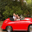

In [4]:
itorch.image(trainset.data[100])
print(classes[trainset.label[100]])

In [5]:
setmetatable(trainset, 
    {__index = function(t, i)
                return {t.data[i], t.label[i]}
            end}
);
trainset.data = trainset.data:double()

function trainset:size() 
    return self.data:size(1) 
end

In [6]:
print(trainset:size())

10000	


In [7]:
print(trainset[33])

{
  1 : DoubleTensor - size: 3x32x32
  2 : 2
}


2	


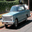

In [8]:
itorch.image(trainset[33][1])
print(trainset[33][2])

In [9]:
redChannel = trainset.data[{ {}, {1}, {}, {} }]

In [10]:
print(#redChannel)


 10000
     1
    32
    32
[torch.LongStorage of size 4]



In [14]:
mean = {}
stdv = {}
for i=1,3 do
    mean[i] = trainset.data[{ {}, {i}, {}, {}}]:mean()
    print('Channel ' .. i ..', Mean:' .. mean[i])
    trainset.data[{{}, {i}, {}, {}}]:add(-mean[i])
    
    stdv[i] = trainset.data[{{}, {i}, {}, {}}]:std()
    print('Channel '.. i .. ', Standard Deviation: '.. stdv[i])
    trainset.data[{{}, {i}, {}, {}}]:div(stdv[i])
end

Channel 1, Mean:125.83175029297	


Channel 1, Standard Deviation: 63.143400842609	


Channel 2, Mean:123.26066621094	


Channel 2, Standard Deviation: 62.369209019002	


Channel 3, Mean:114.03068681641	


Channel 3, Standard Deviation: 66.965808411114	


In [15]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.Linear(120, 84))
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

In [16]:
criterion = nn.ClassNLLCriterion()

In [17]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5

In [18]:
trainer:train(trainset)

# StochasticGradient: training	


# current error = 1.9550357407326	


# current error = 1.6487807353503	


# current error = 1.5374101769351	


# current error = 1.4714822875898	


# current error = 1.4191478465797	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.4191478465797	



In [21]:
testset.data = testset.data:double()
for i=1,3 do
    testset.data[{{}, {i}, {}, {}}]:add(-mean[i])
    testset.data[{{}, {i}, {}, {}}]:div(stdv[i])
end

In [23]:
horse = testset.data[100]
print(horse:mean(), horse:std())

0.59066009532189	1.0665356205025	


In [24]:
print(classes[testset.label[100]])

horse	


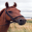

In [25]:
itorch.image(testset.data[100])

In [26]:
predicted = net:forward(testset.data[100])

In [28]:
print(predicted:exp())

 0.0083
 0.0332
 0.1321
 0.2095
 0.1904
 0.1356
 0.0233
 0.1509
 0.0021
 0.1146
[torch.DoubleTensor of size 10]



In [29]:
for i=1,predicted:size(1) do
    print(classes[i], predicted[i])
end

airplane	

0.0082503043357994	
automobile	0.033234730987859	
bird	0.13209812571884	
cat	

0.20953917061256	
deer	0.19037076489409	


dog	0.135629039372	
frog	0.023341857754728	


horse	0.15088512573799	
ship	0.0020804135598875	


truck	0.11455758818564	


In [30]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

In [31]:
print(correct, 100*correct/10000 .. ' % ')

4794	47.94 % 	


In [32]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end

In [33]:
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	56.1 %	
automobile	58 %	
bird	37.5 %	
cat	41.6 %	
deer	38.4 %	
dog	32.1 %	
frog	47.4 %	
horse	67.2 %	
ship	50 %	
truck	51.1 %	


In [34]:
require 'cunn';

[string "require 'cunn';..."]:1: module 'cunn' not found:
	no field package.preload['cunn']
	no file '/home/zjmwqx/.luarocks/share/lua/5.1/cunn.lua'
	no file '/home/zjmwqx/.luarocks/share/lua/5.1/cunn/init.lua'
	no file '/home/zjmwqx/torch/install/share/lua/5.1/cunn.lua'
	no file '/home/zjmwqx/torch/install/share/lua/5.1/cunn/init.lua'
	no file './cunn.lua'
	no file '/home/zjmwqx/torch/install/share/luajit-2.1.0-alpha/cunn.lua'
	no file '/usr/local/share/lua/5.1/cunn.lua'
	no file '/usr/local/share/lua/5.1/cunn/init.lua'
	no file '/home/zjmwqx/.luarocks/lib/lua/5.1/cunn.so'
	no file '/home/zjmwqx/torch/install/lib/lua/5.1/cunn.so'
	no file './cunn.so'
	no file '/usr/local/lib/lua/5.1/cunn.so'
	no file '/usr/local/lib/lua/5.1/loadall.so'
stack traceback:
	[C]: in function 'require'
	[string "require 'cunn';..."]:1: in main chunk
	[C]: in function 'xpcall'
	/home/zjmwqx/torch/install/share/lua/5.1/itorch/main.lua:179: in function </home/zjmwqx/torch/install/share/lua/5.1/itorch/main.lua:143>
	/home/zjmwqx/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/home/zjmwqx/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/home/zjmwqx/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/home/zjmwqx/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/home/zjmwqx/torch/install/share/lua/5.1/itorch/main.lua:350: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00405ea0: 